In [9]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [10]:
file_path = Path("aapl.csv")
aapl_df = pd.read_csv(file_path, index_col="Date", parse_dates=True, infer_datetime_format=True)
aapl_df.dropna(inplace=True)
aapl_df.sort_index(inplace=True)
df = aapl_df.iloc[-1512:]
df.head(30)

,Open,High,Low,Close,Volume
Date,,,,,
2016-04-11,27.24250,27.6525,27.2075,27.2550,117630072
2016-04-12,27.33500,27.6250,27.1650,27.6100,108929300
2016-04-13,27.70000,28.0850,27.7000,28.0100,133029264
2016-04-14,27.90500,28.0975,27.8325,28.0250,101895692
2016-04-15,28.02750,28.0750,27.4325,27.4625,187755876
2016-04-18,27.22250,27.2375,26.7350,26.8700,243285844
2016-04-19,26.97000,27.0000,26.5575,26.7275,129539516
2016-04-20,26.66000,27.0225,26.5150,26.7825,122444120
2016-04-21,26.73250,26.7325,26.3800,26.4925,126210100


In [31]:
from collections import deque
import random

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.9
        self.epsilon = 0.45
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))   
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                         inventory.append(self.trend[t])
                         starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [32]:
close = aapl_df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\jerem\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
C:\Users\jerem\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.


epoch: 10, total rewards: 12191.956556.3, cost: 0.227150, total money: 6974.452581
epoch: 20, total rewards: 4118.329419.3, cost: 0.353912, total money: 10476.899919
epoch: 30, total rewards: 1350.174549.3, cost: 0.356510, total money: 11195.444549
epoch: 40, total rewards: 1236.225411.3, cost: 0.308080, total money: 11236.225411
epoch: 50, total rewards: 872.519478.3, cost: 0.252376, total money: 10872.519478
epoch: 60, total rewards: 922.471399.3, cost: 0.228933, total money: 10922.471399
epoch: 70, total rewards: 1011.220697.3, cost: 0.202810, total money: 11011.220697
epoch: 80, total rewards: 1076.517285.3, cost: 0.184305, total money: 11076.517285
epoch: 90, total rewards: 951.962510.3, cost: 0.218566, total money: 10951.962510
epoch: 100, total rewards: 967.509030.3, cost: 0.155773, total money: 10967.509030
epoch: 110, total rewards: 1390.223254.3, cost: 0.145577, total money: 11390.223254
epoch: 120, total rewards: 1138.705784.3, cost: 0.147128, total money: 11138.705784
epoch

In [33]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 89: buy 1 unit at price 0.244428, total balance 9999.755572
day 90, sell 1 unit at price 0.242839, investment -0.650089 %, total balance 9999.998411,
day 187: buy 1 unit at price 0.268035, total balance 9999.730376
day 188, sell 1 unit at price 0.261607, investment -2.398194 %, total balance 9999.991983,
day 474: buy 1 unit at price 0.495178, total balance 9999.496805
day 475, sell 1 unit at price 0.495178, investment 0.000000 %, total balance 9999.991983,
day 606: buy 1 unit at price 0.898214, total balance 9999.093769
day 607, sell 1 unit at price 0.931964, investment 3.757456 %, total balance 10000.025733,
day 615: buy 1 unit at price 0.965178, total balance 9999.060555
day 616, sell 1 unit at price 0.977678, investment 1.295098 %, total balance 10000.038233,
day 626: buy 1 unit at price 1.143750, total balance 9998.894483
day 627, sell 1 unit at price 1.152678, investment 0.780590 %, total balance 10000.047161,
day 635: buy 1 unit at price 1.130000, total balance 9998.917161
da

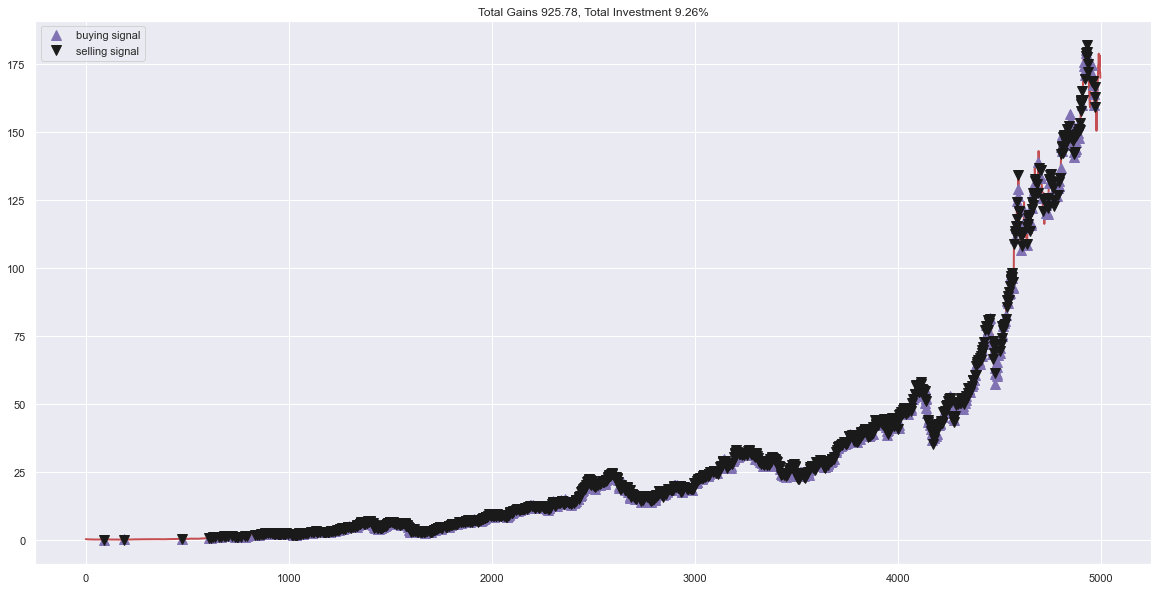

In [34]:
fig = plt.figure(figsize = (20,10))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Total Gains %.2f, Total Investment %.2f%%'%(total_gains, invest))
plt.legend()
plt.show()